In [1]:
import numpy as np
import scipy
from scipy import signal
from matplotlib import pyplot as plt
import os

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

## File naming

Describe the file names and what they tell us...

- nfc as extension
- specify sample rate, usb standard, antenna, bandwidth...

In [34]:
PATH = "../data/recordings/"

In [35]:
files = [file for file in os.listdir(PATH) if file.endswith(".nfc")]
files

['2.0-2.nfc',
 '3.0-2_lowpassed.nfc',
 '3.0-antenna-probing.nfc',
 '2.0-1.nfc',
 '3.0-antenna-1.nfc',
 '3.0-antenna-2.nfc',
 '3.0-1.nfc']

## Parse file

To parse the file, several element must be taken into account. First, the type of the data in the binary file. Here, we recorded our data as `complex64` values, so we must read them as such as well.

Second, the same sample rate used to record the signal must be used here as well.

In [33]:
samp_rate = 2e6  # Is it enough? Nyquist...
nfft = 1024

# The number of samples per period is equal to the sample rate divided by the frequency
npp = samp_rate / 13.56e6
print(npp)
print(2 * 13.56e6)

0.14749262536873156
27120000.0


In [22]:
file = files[5]
data = np.fromfile(os.path.join(PATH, file), dtype=scipy.complex64)

#for file in files:
    #sample_rate, data = wav.read(os.path.join(PATH, file))
    #all_X[file[:-4]] = (sample_rate, data)

## Visualize

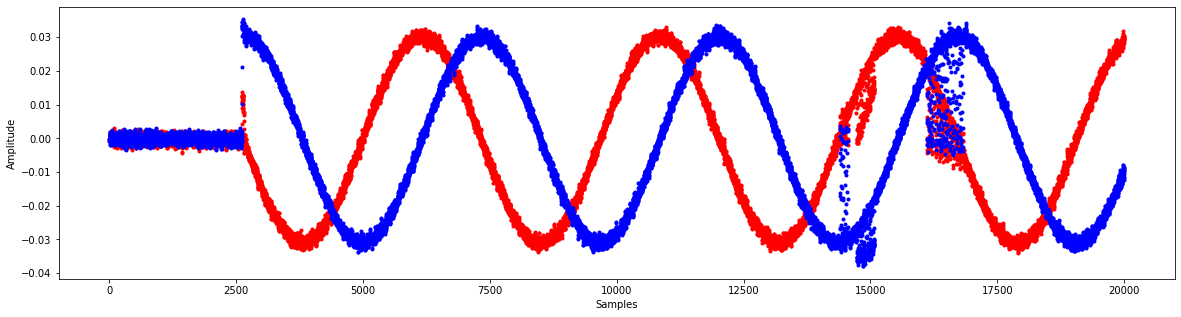

In [30]:
start = 6800000
end = 6820000

plt.plot(np.real(data[start:end]), 'r.', np.imag(data[start:end]), 'b.')
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

The signal is mostly very clean, but there are strange artifacts in the recording.

One of them is around the 68'000th point and another around the 340'000th point.

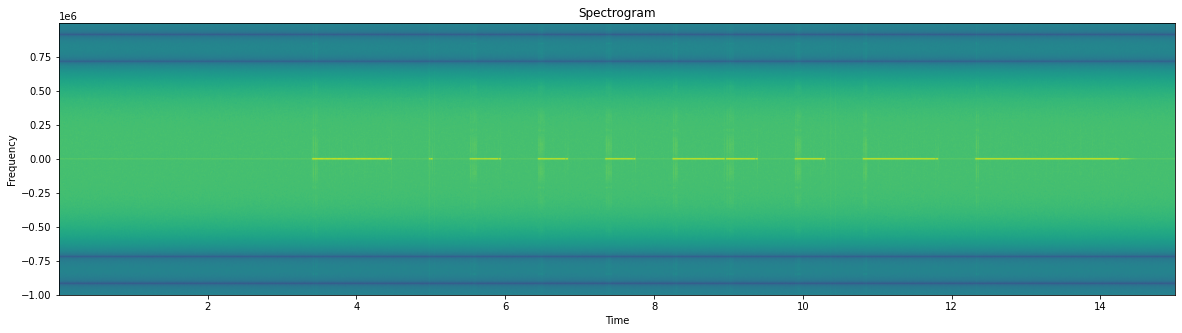

In [31]:
plt.specgram(data[0:int(3e7)], NFFT=nfft, Fs=samp_rate)
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

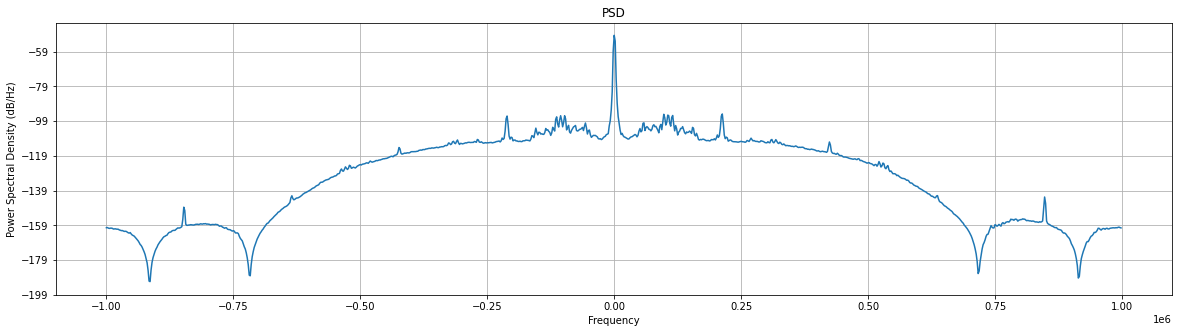

In [8]:
plt.psd(data[0:int(1e6)], NFFT=nfft, Fs=samp_rate)
plt.title("PSD")
plt.show()

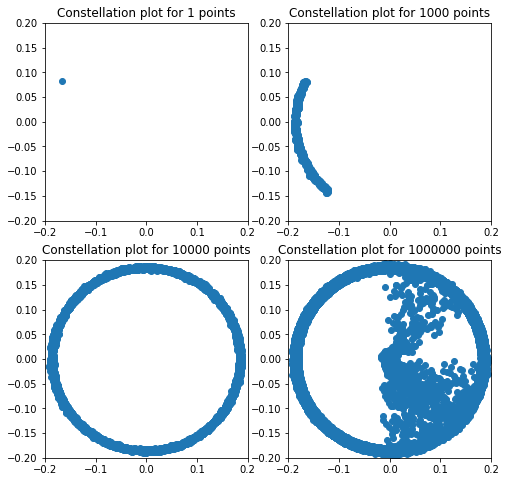

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

nbr_points = [1, 1000, 10000, 1000000]

for i, ax in (t for t in zip(nbr_points, axs.flat)):
    ax.axis([-0.2, 0.2, -0.2, 0.2])
    ax.scatter(np.real(data[0:i]), np.imag(data[0:i]))
    ax.set_title("Constellation plot for {} points".format(i))

## Continuous wavelet transform

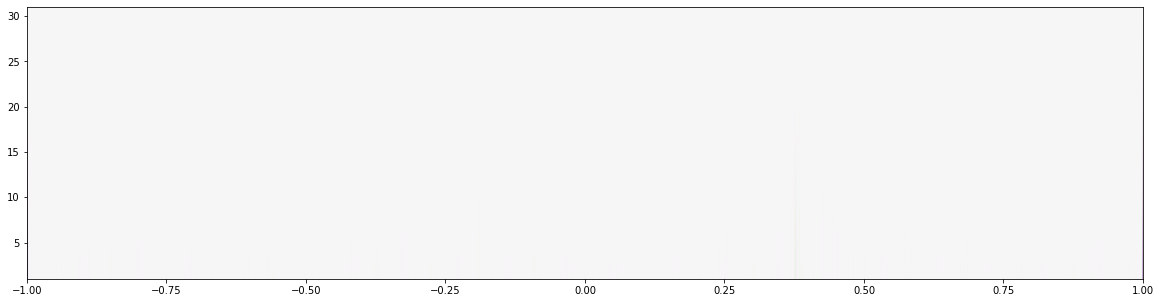

In [10]:
widths = np.arange(1, 31)
cwt = signal.cwt(np.real(data[0:int(1e5)]), signal.ricker, widths)
plt.imshow(cwt, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwt).max(), vmin=-abs(cwt).max())
plt.show()